# Models training
In this notebook we train and analyze LSTM models, compare them and tune them to get the best results. We will work with a small subset due to low hardware availability.

## 0.1 Load variable
This notebook is a direct continuation of data_preprocessing.ipynb. We start by loading the necessary libraries variables from that.

In [172]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from collections import Counter
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from landmarks_augmentator import produce_augmentations

In [173]:
df = pd.read_csv('data/video_labels.csv',dtype={'video_id': object})
words = dict(Counter(df.word).most_common(31)).keys()

data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object})
data_info = data_info.loc[data_info.word.isin(words)]

POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1

def load_landmarks(filename):
    working_dir = './'
    try:
        with open(os.path.join(working_dir,'data',filename), 'rb') as file:
            lmarks = pickle.load(file)
    except FileNotFoundError:
        # If the file doesn't exist, initialize the variable
        print(f'Could not open {filename}')
        lmarks = {} # This value contains the landmarks points of all frames, in all the videos
    return lmarks


video_ids = list(data_info.video_id)
subset_landmarks = {}
for i in range(1,8):
    lmarks = load_landmarks(f'landmarks_vol{i}.pkl')
    for key, value in lmarks.items():
        if key in video_ids:
            subset_landmarks[key] = value


landmarks = {key: [] for key in subset_landmarks.keys()}

LANDMARKS_LENGTH = 543 # Fixed and determined by the mediapipe package. The total number of landmarks in the 4 categories.

for key, video in subset_landmarks.items():
    new_video = np.zeros((len(video),LANDMARKS_LENGTH,3)) # frame x landdmarks x coordinates
    for i, frame in enumerate(video):
        pose = frame['pose'][:,:3] if frame['pose'].shape == (33, 4) else frame['pose'].reshape((33, 4))[:,:3]
        lh = frame['lh'] if frame['lh'].shape == (21, 3) else frame['lh'].reshape((21, 3))
        rh = frame['rh'] if frame['rh'].shape == (21, 3) else frame['rh'].reshape((21, 3))
        face = frame['face'] if frame['face'].shape == (468, 3) else frame['face'].reshape((468, 3))
        frame_landmarks = np.vstack((pose, lh, rh, face))
        new_video[i] = frame_landmarks
    landmarks[key] = new_video

del lmarks, subset_landmarks

Could not open landmarks_vol1.pkl
Could not open landmarks_vol2.pkl
Could not open landmarks_vol3.pkl
Could not open landmarks_vol4.pkl
Could not open landmarks_vol5.pkl
Could not open landmarks_vol6.pkl
Could not open landmarks_vol7.pkl


In [200]:
with open('landmarks_31_subset.pkl', 'rb') as file:
    subset_landmarks = pickle.load(file)
for key in list(subset_landmarks.keys()):
    if len(subset_landmarks[key]) == 0:
        del subset_landmarks[key]

LANDMARKS_LENGTH = 543 # Fixed and determined by the mediapipe package. The total number of landmarks in the 4 categories.

data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object},index_col=0)
data_info = data_info.loc[data_info.video_id.isin(subset_landmarks.keys())]
subset_words = data_info.loc[data_info.video_id.isin(subset_landmarks.keys()),'word'].unique()

POSE = np.hstack((np.ones(33), np.zeros(21+21+468))) == 1
LH = np.hstack((np.zeros(33), np.ones(21), np.zeros(21+468))) == 1
RH = np.hstack((np.zeros(33+21), np.ones(21), np.zeros(468))) == 1
FACE = np.hstack((np.zeros(33+21+21), np.ones(468))) == 1

In [215]:
landmarks = subset_landmarks

In [201]:
data_info

,fps_x,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,word,fps_y,width,height,duration
bbox,,,,,,,,,,,,,,,
"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,25.0,256,256,2.56
"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,book,25.0,256,256,2.56
"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,book,25.0,256,256,1.88
"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,book,25.0,256,256,4.96
"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,book,25.0,256,256,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[185, 61, 560, 400]",25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/what.mp4,0,62988,what,25.0,256,256,2.96
"[52, 24, 246, 192]",25,-1,1,25,10,signingsavvy,test,https://www.signingsavvy.com/signs/mp4/23/2346...,1,62975,what,25.0,256,256,1.80
"[179, 13, 606, 414]",25,-1,1,27,36,startasl,val,https://s3-us-west-1.amazonaws.com/files.start...,1,62965,what,25.0,256,256,2.52


In [202]:
subset_words

array(['book', 'drink', 'computer', 'before', 'chair', 'go', 'clothes',
       'who', 'candy', 'cousin', 'deaf', 'fine', 'help', 'no', 'thin',
       'walk', 'year', 'yes', 'all', 'black', 'cool', 'finish', 'hot',
       'like', 'many', 'mother', 'now', 'orange', 'table', 'thanksgiving',
       'what'], dtype=object)

## 0.2 Test-train split

List of hyperparameters:
- **Dimensions** Check wether 3D is significanly more sufficient than 2D
- **Face landmarks** Do the face landmarks contribute much? If yes, how many of them should we take?


In [216]:
PICKED_FRAMES = 24 # min([len(video) for video in landmarks.values()])
DIMENSTIONS = 3
USE_AUGMENTATIONS = True# Use augmented videos
    

In [86]:
#train_signer_ids = [118, 31, 59, 11, 115, 94, 6, 21, 10, 38, 56, 41, 4, 45, 32, 46, 13,
#                    42, 39, 17, 89, 60, 35, 15, 3, 92, 93, 34, 107, 28, 99, 37, 8, 97,
#                    70, 19, 91, 106, 63, 29, 26, 117, 66, 119, 50, 103, 120, 95, 78, 27,
#                    108, 57, 53, 75, 104, 43, 40, 77, 1, 33, 22, 105, 48, 73, 23]
#val_signer_ids = [2, 52, 12, 98, 88]
#test_signer_ids = [59, 115, 90, 4, 116, 100, 101, 102, 96, 90]
#
#num_of_words = data_info[data_info["word"].isin(subset_words)]["word"].nunique()
#subset_data = data_info[data_info["word"].isin(subset_words)]
#subset_train_data = subset_data[subset_data["signer_id"].isin(train_signer_ids)]
#subset_test_data = subset_data[subset_data["signer_id"].isin(val_signer_ids)]
#subset_validation_data = subset_data[subset_data["signer_id"].isin(test_signer_ids)]
#
#print(f"subset train data count: {len(subset_train_data)}")
#print(f"subset test data count: {len(subset_test_data)}")
#print(f"subset validation data count: {len(subset_validation_data)}")
#print(f"num of words: {num_of_words}")

In [217]:
# train, val, and test as given by the data authors, should find a better split
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])

In [218]:
test_landmarks = {id:video for id, video in landmarks.items() if id in test_ids}
validation_landmarks = {id:video for id, video in landmarks.items() if id in validation_ids}


## 0.3 Produce Augmentations 
For train set only

In [219]:
#subset_landmarks = produce_augmentations(subset_landmarks,data_info)
train_landmarks = {id:video for id, video in landmarks.items() if id in train_ids}
len(train_landmarks)


462

In [221]:
train_landmarks = produce_augmentations(train_landmarks, data_info.loc[data_info.video_id.isin(train_landmarks.keys())])
len(train_landmarks)

2265

In [222]:
test_landmarks_avg = {id:video for id, video in landmarks.items() if id in test_ids}
validation_landmarks_avg = {id:video for id, video in landmarks.items() if id in validation_ids}
train_landmarks_avg = {id:video for id, video in landmarks.items() if id in train_ids}
train_landmarks_avg = produce_augmentations(train_landmarks_avg, data_info.loc[data_info.video_id.isin(train_landmarks_avg.keys())])

## 0.3 Prepare data to fit in LSTM
Take same amount of frames from each video.
<p style="color:red;">hopefully this is a temporary phase in the development </p>

In [223]:
def pick_frames(video,num_frames):
    ''' Take a subset of the frames, evenly spread over the whole video
    ----------------------------------------------------------------------------------------------------------
        EDIT: After getting the missing data, some video are too short and need more frames instad
              Will it bias the predictions? Nee to consider discarding these examples.
              OR ask chatGPT to write a function to make it a smooth "slow motion", I don't have time for this
    ----------------------------------------------------------------------------------------------------------
    '''
    if len(video) == num_frames:
        return video
    if len(video) < num_frames:
        video_longer = video.copy()
        for _ in range(len(video),num_frames):
            video_longer = np.vstack((video_longer,[video_longer[-1]]))
        return video_longer
    step_size = len(video) // num_frames
    video_shorter = video[::step_size][:num_frames]
    return video_shorter

In [224]:
words = subset_words 

#lstm_landmarks = {}
#for word in words:
#    videos = data_info.loc[data_info.word==word,'video_id']
#    for vid in videos:
#        lstm_landmarks[vid] = pick_frames(subset_landmarks[vid][:,POSE+LH+RH,:DIMENSTIONS].copy(),PICKED_FRAMES)
#        for key in subset_landmarks:
#            if key.split('_')[0] == vid:
#                lstm_landmarks[vid] = pick_frames(subset_landmarks[vid][:,POSE+LH+RH,:DIMENSTIONS].copy(),PICKED_FRAMES)
#for id, video in list(subset_landmarks.items()):
#    if id not in train_ids:
#        subset_landmarks[id] = pick_frames(video[:,POSE+LH+RH,:DIMENSTIONS],PICKED_FRAMES)
#    else: # Clear up space, maybe irrelevant because we soon delete the whole subset_landmarks object
#        del subset_landmarks[id]

for id, video in train_landmarks.items():
    train_landmarks[id] = pick_frames(video,PICKED_FRAMES)
    original_id = id.split('_')[0]
    if original_id != id and id not in data_info.video_id: # if augmented type, add its label to the data_info table
        augmented_row = data_info.loc[data_info.video_id==original_id,:]
        data_info.loc[data_info['video_id'] == original_id, 'video_id'] = id
        data_info = pd.concat([data_info, augmented_row])

print(f'{len(train_landmarks)} videos in total for {len(words)} words')

for id, video in test_landmarks.items():
    test_landmarks[id] = pick_frames(video, PICKED_FRAMES)

print(f'{len(test_landmarks)} videos in total for {len(words)} words')

for id, video in validation_landmarks.items():
    validation_landmarks[id] = pick_frames(video, PICKED_FRAMES)

print(f'{len(validation_landmarks)} videos in total for {len(words)} words')

2265 videos in total for 31 words
86 videos in total for 31 words
109 videos in total for 31 words


## 0.4 Train test split

In [225]:
for video_id, video in train_landmarks.items():
    train_landmarks[video_id] = np.array([frame.flatten() for frame in video])
for video_id, video in test_landmarks.items():
    test_landmarks[video_id] = np.array([frame.flatten() for frame in video])
for video_id, video in validation_landmarks.items():
    validation_landmarks[video_id] = np.array([frame.flatten() for frame in video])

X_train = np.array([video for video in train_landmarks.values()])
y_train = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in train_landmarks.keys()]

X_val = np.array([video for video in validation_landmarks.values()])
y_val = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in validation_landmarks.keys()]

X_test = np.array([video for video in test_landmarks.values()])
y_test = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in test_landmarks.keys()]

# Shuffle the train set
num_instances = X_train.shape[0]
shuffled_indices = np.arange(num_instances)
np.random.shuffle(shuffled_indices)
X_train = X_train[shuffled_indices]
y_train = np.array(y_train)[shuffled_indices]

## 1.1 BASELINE MODEL - Landmarks + Regression Model

In [226]:
# Modification to X values to suit model

# Modification 1: Flatten all frames
X_train_mod1 = X_train.reshape(X_train.shape[0], -1)
X_test_mod1 = X_test.reshape(X_test.shape[0], -1)
X_val_mod1 = X_val.reshape(X_val.shape[0], -1)

# Modification 2: Average across frames
for video_id, video in train_landmarks_avg.items():
    train_landmarks_avg[video_id] = np.array([frame.flatten() for frame in video])
for video_id, video in test_landmarks_avg.items():
    test_landmarks_avg[video_id] = np.array([frame.flatten() for frame in video])
for video_id, video in validation_landmarks_avg.items():
    validation_landmarks_avg[video_id] = np.array([frame.flatten() for frame in video])

for id, video in train_landmarks_avg.items():
    train_landmarks_avg[id] = np.mean(video, axis=0)
    original_id = id.split('_')[0]
    if original_id != id and id not in data_info.video_id: # if augmented type, add its label to the data_info table
        augmented_row = data_info.loc[data_info.video_id==original_id,:]
        data_info.loc[data_info['video_id'] == original_id, 'video_id'] = id
        data_info = pd.concat([data_info, augmented_row])

print(f'{len(train_landmarks_avg)} videos in total for {len(words)} words')

for id, video in test_landmarks_avg.items():
    test_landmarks_avg[id] = np.mean(video, axis=0)

print(f'{len(test_landmarks_avg)} videos in total for {len(words)} words')

for id, video in validation_landmarks_avg.items():
    validation_landmarks_avg[id] = np.mean(video, axis=0)

print(f'{len(validation_landmarks_avg)} videos in total for {len(words)} words')

2265 videos in total for 31 words
86 videos in total for 31 words
109 videos in total for 31 words


In [227]:
X_train_mod2 = np.array([video for video in train_landmarks_avg.values()])
y_train_mod2 = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in train_landmarks_avg.keys()]

X_val_mod2 = np.array([video for video in validation_landmarks_avg.values()])
y_val_mod2 = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in validation_landmarks_avg.keys()]

X_test_mod2 = np.array([video for video in test_landmarks_avg.values()])
y_test_mod2 = [(data_info.loc[data_info['video_id'] == id, 'word'].tolist()[0]) for id in test_landmarks_avg.keys()]


In [228]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

In [229]:
model_lg = logistic_regression(X_train_mod1, X_val_mod1, y_train, y_val)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1212007     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43399D+00    |proj g|=  2.78105D-02


 This problem is unconstrained.



At iterate   50    f=  1.47600D+00    |proj g|=  6.28426D-02

At iterate  100    f=  7.33890D-01    |proj g|=  1.22999D-02

At iterate  150    f=  5.13248D-01    |proj g|=  5.63180D-03

At iterate  200    f=  4.63181D-01    |proj g|=  1.37904D-03

At iterate  250    f=  4.35292D-01    |proj g|=  1.23227D-03

At iterate  300    f=  4.15848D-01    |proj g|=  3.01197D-03

At iterate  350    f=  4.07796D-01    |proj g|=  6.05686D-04

At iterate  400    f=  4.05272D-01    |proj g|=  2.58720D-04

At iterate  450    f=  4.04219D-01    |proj g|=  2.08814D-04

At iterate  500    f=  4.03794D-01    |proj g|=  2.49687D-04

At iterate  550    f=  4.03616D-01    |proj g|=  1.81973D-04

At iterate  600    f=  4.03536D-01    |proj g|=  1.94993D-04

At iterate  650    f=  4.03477D-01    |proj g|=  2.14389D-04

At iterate  700    f=  4.03431D-01    |proj g|=  1.80767D-04

At iterate  750    f=  4.03387D-01    |proj g|=  1.69433D-04

At iterate  800    f=  4.03321D-01    |proj g|=  2.09239D-04

At iter

/opt/homebrew/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wi

In [230]:
model_svm = svm(X_train_mod1, X_val_mod1, y_train, y_val)

Accuracy: 0.13761467889908258
Classification Report:               precision    recall  f1-score   support

         all       0.00      0.00      0.00         1
      before       0.00      0.00      0.00         1
       black       0.50      0.33      0.40         3
        book       0.00      0.00      0.00         2
       candy       0.17      0.33      0.22         3
       chair       0.00      0.00      0.00         3
     clothes       0.14      0.25      0.18         4
    computer       0.00      0.00      0.00         5
        cool       0.20      0.25      0.22         4
      cousin       0.25      0.25      0.25         4
        deaf       0.25      0.25      0.25         4
       drink       0.00      0.00      0.00         6
        fine       0.00      0.00      0.00         4
      finish       0.50      0.25      0.33         4
          go       0.00      0.00      0.00         4
        help       0.00      0.00      0.00         4
         hot       0.00     

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [231]:
model_rf = random_forest(X_train_mod1, X_val_mod1, y_train, y_val)

Accuracy: 0.3486238532110092
Classification Report:               precision    recall  f1-score   support

         all       0.00      0.00      0.00         1
      before       0.00      0.00      0.00         1
       black       1.00      0.67      0.80         3
        book       0.00      0.00      0.00         2
       candy       0.00      0.00      0.00         3
       chair       0.33      0.33      0.33         3
     clothes       0.33      0.50      0.40         4
    computer       0.25      0.20      0.22         5
        cool       0.20      0.25      0.22         4
      cousin       0.25      0.50      0.33         4
        deaf       0.67      0.50      0.57         4
       drink       0.75      0.50      0.60         6
        fine       1.00      0.50      0.67         4
      finish       1.00      0.25      0.40         4
          go       0.25      0.25      0.25         4
        help       1.00      0.75      0.86         4
         hot       0.25      

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [232]:
model_lg_avg = logistic_regression(X_train_mod2, X_val_mod2, y_train_mod2, y_val_mod2)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        50530     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43399D+00    |proj g|=  2.72231D-02

At iterate   50    f=  2.57884D+00    |proj g|=  6.86561D-03

At iterate  100    f=  2.50491D+00    |proj g|=  1.85636D-03

At iterate  150    f=  2.49482D+00    |proj g|=  1.64768D-03

At iterate  200    f=  2.49128D+00    |proj g|=  2.48277D-03

At iterate  250    f=  2.48180D+00    |proj g|=  4.09370D-03

At iterate  300    f=  2.47460D+00    |proj g|=  6.82231D-04

At iterate  350    f=  2.47362D+00    |proj g|=  3.02018D-04

At iterate  400    f=  2.47351D+00    |proj g|=  1.72656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [233]:
model_svm_avg = svm(X_train_mod2, X_val_mod2, y_train_mod2, y_val_mod2)

Accuracy: 0.22018348623853212
Classification Report:               precision    recall  f1-score   support

         all       0.00      0.00      0.00         1
      before       0.00      0.00      0.00         1
       black       0.00      0.00      0.00         3
        book       0.50      0.50      0.50         2
       candy       0.00      0.00      0.00         3
       chair       0.00      0.00      0.00         3
     clothes       0.18      0.50      0.27         4
    computer       0.00      0.00      0.00         5
        cool       0.00      0.00      0.00         4
      cousin       0.29      0.50      0.36         4
        deaf       0.20      0.25      0.22         4
       drink       0.20      0.17      0.18         6
        fine       0.00      0.00      0.00         4
      finish       0.67      0.50      0.57         4
          go       0.33      0.25      0.29         4
        help       1.00      0.50      0.67         4
         hot       0.50     

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [234]:
model_rf_avg = random_forest(X_train_mod2, X_val_mod2, y_train_mod2, y_val_mod2)

Accuracy: 0.24770642201834864
Classification Report:               precision    recall  f1-score   support

         all       0.00      0.00      0.00         1
      before       0.00      0.00      0.00         1
       black       0.00      0.00      0.00         3
        book       0.00      0.00      0.00         2
       candy       0.33      0.33      0.33         3
       chair       0.00      0.00      0.00         3
     clothes       0.40      0.50      0.44         4
    computer       0.50      0.40      0.44         5
        cool       0.11      0.25      0.15         4
      cousin       0.22      0.50      0.31         4
        deaf       0.50      0.25      0.33         4
       drink       0.40      0.33      0.36         6
        fine       0.00      0.00      0.00         4
      finish       0.25      0.25      0.25         4
          go       0.33      0.25      0.29         4
        help       0.67      0.50      0.57         4
         hot       0.00     

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 1.2 BASELINE MODEL - Landmarks + LSTM

In [235]:
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam


MODEL_VERSION = 3 # Model 3 is trained on ~500 words of data

def load_tf_model(folder_path):
    if not os.path.exists(folder_path):
        return False
    for file in os.listdir(folder_path):
        if file.endswith('.keras'):
            return keras.saving.load_model(os.path.join(folder_path,file))
    return False
folder_path = os.path.join('sign-to-text-interface','serving','lstm',str(MODEL_VERSION))
#model = load_tf_model(folder_path)
model = False

index_to_word = {word: i for i, word in enumerate(words)}
y_train_categorical = to_categorical([index_to_word[word] for word in y_train], num_classes=len(words))
y_val_categorical = to_categorical([index_to_word[word] for word in y_val], num_classes=len(words))
if not model:    
    input_shape = (X_train[0].shape)  #Hopefully we can do variable number of frames later
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(256, return_sequences=False, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(words), activation='softmax'))
    adam_optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 24, 128)        │       900,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 31)             │        15,903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,639,199 (6.25 MB)

 Trainable params: 1,639,199 (6.25 MB)

 Non-trainable params: 0 (0.00 B)

In [236]:
from keras.callbacks import ModelCheckpoint

#filepath = "model_500.h5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

#if os.path.exists(filepath):
    #print('loaded weights and procceed training')
    #model.load_weights(checkpoint_filepath)
#history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=8, callbacks=callbacks_list, validation_data = (X_val, y_val_categorical))
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=8, validation_data = (X_val, y_val_categorical))

Epoch 1/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - categorical_accuracy: 0.0427 - loss: 4.0705 - val_categorical_accuracy: 0.0367 - val_loss: 3.3659
Epoch 2/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - categorical_accuracy: 0.0644 - loss: 3.1739 - val_categorical_accuracy: 0.0642 - val_loss: 3.0890
Epoch 3/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - categorical_accuracy: 0.0760 - loss: 3.0012 - val_categorical_accuracy: 0.0642 - val_loss: 3.0764
Epoch 4/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - categorical_accuracy: 0.0802 - loss: 3.0191 - val_categorical_accuracy: 0.0642 - val_loss: 3.1112
Epoch 5/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - categorical_accuracy: 0.0808 - loss: 2.9995 - val_categorical_accuracy: 0.0826 - val_loss: 3.0820
Epoch 6/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - categorical_accuracy: 0.0862 - loss: 2.9122 - val_categorical_accuracy: 0.0459 - val_loss: 3.1145
Epoch 7/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - categorical_a

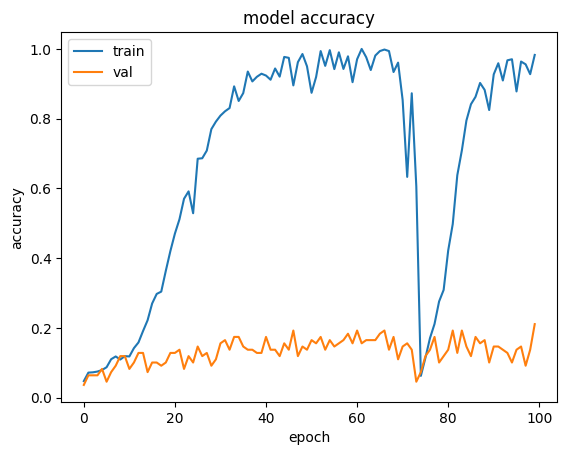

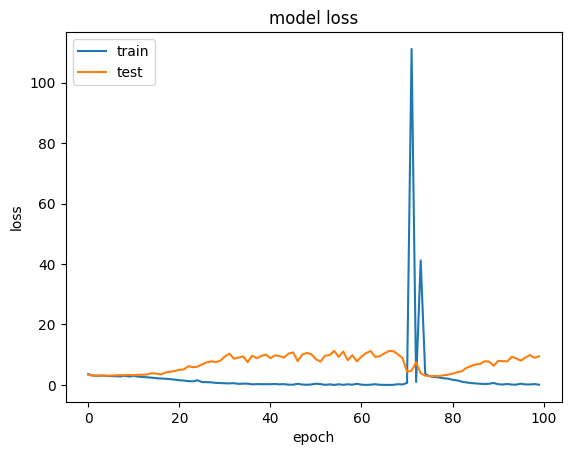

In [237]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Load the weights with the best performance

In [45]:
os.path.join('sign-to-text-interface','serving','lstm',str(MODEL_VERSION),'sign_to_text.keras')

'sign-to-text-interface/serving/lstm/3/sign_to_text.keras'

In [275]:
model.load_weights(filepath)
model.save(os.path.join('sign-to-text-interface','serving','lstm',str(MODEL_VERSION),'sign_to_text.keras'))

Let's find how many correctly classified instances we get

In [238]:
count_train = Counter(y_train)
def predictions_stats(X_test, y_test):
    correct = {}
    for i,j in enumerate(model.predict(X_test).argmax(axis=1)):
        if y_test[i] == words[j]:
            correct[y_test[i]] = correct.get(y_test[i],0) + 1
    count_test = Counter(y_test)
    pred_stats = []
    for word, count in correct.items():
        row_data = {"word": word, "correct_count": count, "appeared_test": count_test.get(word, 0), "train_instances": count_train.get(word, 0)}
        pred_stats.append(row_data)

    # Concatenate the list of dictionaries to the DataFrame
    pred_stats = pd.concat([ pd.DataFrame(columns=["word","correct_count","appeared_test","train_instances"]), pd.DataFrame(pred_stats)], ignore_index=True)
    return pred_stats
display(predictions_stats(X_val, y_val))
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


,word,correct_count,appeared_test,train_instances
0,drink,2,6,100
1,computer,2,5,80
2,who,1,4,90
3,cousin,1,4,80
4,deaf,1,4,80
5,thin,1,4,75
6,year,2,4,75
7,black,1,3,50
8,hot,2,3,75
9,now,1,3,75


The mean and median amount of instances per word in the train set are: 73.06451612903226 75.0


In [239]:
count_train = Counter(y_train)
def predictions_stats(on = 'val'):
    if on == 'val':
        X, y, video_ids = X_val, y_val, validation_ids
    else:
        X, y, video_ids = X_test, y_test, test_ids
    prob_scores = np.zeros((len(y),3), dtype=object)
    for i,j in enumerate(model.predict(X)):
        prob_scores[i,0] = y[i]
        prob_scores[i,1] = (j>j[index_to_word[y[i]]]).sum()# Highest probability means the word got predicted correctly, we want to analyze how close the word was in case it wasn't predicted
#        if y[i] == words[j]:
#            correct[y[i]] = correct.get(y[i],0) + 1
    prob_scores[:,2] = list(data_info.loc[data_info.video_id.isin(video_ids),'video_id'])
    return pd.DataFrame(prob_scores,columns=['word','score','video_id']).sort_values(['score','word'],ascending=[False,True])
    #count_test = Counter(y)
    #for word, count in correct.items():
    #    row_data = {"word": word, "correct_count": count, "appeared_test": count_test.get(word, 0), "train_instances": count_train.get(word, 0)}
    #    pred_stats.append(row_data)
    #pred_stats = pd.concat([ pd.DataFrame(columns=["word","correct_count","appeared_test","train_instances"]), pd.DataFrame(pred_stats)], ignore_index=True)
    #return pred_stats
word_scores = predictions_stats().sort_values(['score','word'],ascending=[True,True])
display(predictions_stats())
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


,word,score,video_id
42,finish,30,21872
73,candy,29,65402
105,table,24,62944
66,chair,23,68192
17,candy,22,69345
...,...,...,...
107,table,0,62988
30,thin,0,08918
16,who,0,67483
33,year,0,13634


The mean and median amount of instances per word in the train set are: 73.06451612903226 75.0


In [241]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_categorical = model.predict(X_val)
y_pred = np.argmax(y_pred_categorical, axis=1)  # Convert predicted categorical labels to numerical labels

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_val_categorical, axis=1), y_pred)

# Compute precision, recall, f1-score, and support for each class
report = classification_report(np.argmax(y_val_categorical, axis=1), y_pred)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix:
[[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [326]:
word_scores.loc[(word_scores.score<10) & (word_scores.score>1)].shape

(121, 3)

<h2 style="color:red">TODO: Continue exploration of model 3 and its results</h2>
<ul style="color:red">
    <li>Make statistics of the results</li>
    <li>Try to train further, perhaps with dropout or normalization</li>
</ul>

Altough I did not output it here above, I noticed that the overfitted model got always only one word correct: "drink", it is worth investigating why. Perhaps the videos for it were too short and therefore the frames were duplicated to fit the input size for the model.

We see that to get better reults we need more augmentations.

In [144]:
# Helper function for self use, get video ids for a word in a particular set
def find_video_id(word,set = validation_ids):
    df = pd.concat([data_info.loc[data_info.video_id==id,['video_id','word']] for id in lstm_landmarks.keys() if id in set])
    return df.loc[df.word == word]
#use like this:
#find_video_id('short',validation_ids)

## 1.3 LSTM Version 2

In [25]:
MODEL_VERSION = 2
folder_path = os.path.join("serving","lstm",str(MODEL_VERSION))
model = load_tf_model(folder_path)

if not model:    
    input_shape = (lstm_landmarks[list(lstm_landmarks.keys())[0]].shape)  #Hopefully we can do variable number of frames later
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape))
    model.add(LSTM(256, return_sequences=True, activation='relu'))
    model.add(LSTM(256, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=False, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(words), activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    model.fit(X_train, y_train_categorical, epochs=100, batch_size=8)
    model.save(os.path.join('serving','lstm',str(MODEL_VERSION),'sign_to_text.keras'))

Epoch 1/100
106/106 [==============================] - 12s 68ms/step - loss: 3.5270 - categorical_accuracy: 0.0462
Epoch 2/100
106/106 [==============================] - 7s 64ms/step - loss: 3.3592 - categorical_accuracy: 0.0581
Epoch 3/100
106/106 [==============================] - 9s 81ms/step - loss: 3.0617 - categorical_accuracy: 0.0652
Epoch 4/100
106/106 [==============================] - 8s 74ms/step - loss: 2.9307 - categorical_accuracy: 0.0841
Epoch 5/100
106/106 [==============================] - 7s 70ms/step - loss: 2.8648 - categorical_accuracy: 0.0900
Epoch 6/100
106/106 [==============================] - 8s 74ms/step - loss: 22.1359 - categorical_accuracy: 0.0995
Epoch 7/100
106/106 [==============================] - 8s 74ms/step - loss: 2.8907 - categorical_accuracy: 0.1066
Epoch 8/100
106/106 [==============================] - 8s 79ms/step - loss: 2.8154 - categorical_accuracy: 0.1055
Epoch 9/100
106/106 [==============================] - 8s 71ms/step - loss: 2.6906 - c

In [31]:
display(per_stats(X_test = X_val,y_test = y_val))
print("The mean and median amount of instances per word in the train set are:",np.mean(list(count_train.values())),np.median(list(count_train.values())))

7/7 [==============================] - 1s 69ms/step


,word,correct_count,appeared_test,train_instances
0,tall,4,8,40
1,man,4,8,40
2,taste,5,5,25
3,dark,4,4,36
4,room,4,8,28
5,dress,5,10,20


The mean and median amount of instances per word in the train set are: 27.225806451612904 28.0


## 1.4 CLIP Embedded

In [31]:
import os
import pickle
import numpy as np
import pandas as pd

# Subset of 500 words -> 7738 Instances
data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object},index_col=0)
top_500 = np.array(Counter(data_info.word).most_common(500))[:,0]
data_info = data_info.loc[data_info.word.isin(top_500),:].reset_index(drop=True)

In [104]:
data_info = pd.read_csv('data/video_labels.csv',dtype={'video_id': object},index_col=0)
data_info['video_id'] = data_info['video_id'].astype('int64')
data_info

,fps_x,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,word,fps_y,width,height,duration
bbox,,,,,,,,,,,,,,,
"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,book,25.0,256,256,2.56
"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,book,25.0,256,256,2.56
"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,book,25.0,256,256,1.88
"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,book,25.0,256,256,4.96
"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,book,25.0,256,256,3.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[76, 17, 236, 240]",25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186,whistle,25.0,256,256,3.56
"[3, 0, 320, 240]",25,-1,1,3,14,handspeak,train,https://www.handspeak.com/word/w/whistle.mp4,0,63187,whistle,25.0,256,256,0.96
"[68, 14, 212, 192]",25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188,whistle,25.0,256,256,1.52


In [116]:
train_ids = list(data_info.loc[data_info.split=='train','video_id'])
validation_ids = list(data_info.loc[data_info.split=='val','video_id'])
test_ids = list(data_info.loc[data_info.split=='test','video_id'])

In [242]:
import cv2

def pick_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Ensure at least one frame is picked
    num_frames = max(num_frames, 1)
    
    # Calculate step size ensuring the last frame is included
    step = max(total_frames // (num_frames - 1), 1)
    
    frames = []

    for i in range(num_frames):
        frame_index = min(i * step, total_frames - 1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames

In [244]:
def arrange_frames_in_image(frames, rows, cols):
    # Calculate the dimensions of the output image
    output_height = rows * frames[0].shape[0]
    output_width = cols * frames[0].shape[1]
    
    # Create an empty black image to arrange frames
    output_image = np.zeros((output_height, output_width, 3), dtype=np.uint8)
    
    # Iterate through frames and place them in the output image
    for i in range(rows):
        for j in range(cols):
            frame_index = i * cols + j
            if frame_index < len(frames):
                frame = frames[frame_index]
                start_row = i * frame.shape[0]
                end_row = start_row + frame.shape[0]
                start_col = j * frame.shape[1]
                end_col = start_col + frame.shape[1]
                output_image[start_row:end_row, start_col:end_col, :] = frame
    
    return output_image

rows, cols = 2, 5

In [245]:
from transformers import CLIPProcessor, CLIPModel
import torch

model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

def embed_images(img):
    inputs = processor(
        images=img,
        return_tensors="pt",
        padding=True,
        max_length=32,
        truncation=True
    )
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features.flatten()

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [88]:
# this is really expensive dont run this
def embed_images_CLIP(video_folder, csv_file_name="data/embed_images_CLIP.csv"):
    processed_videos = []
    count = 0
    for filename in os.listdir(video_folder):
        count = count + 1
        if count % 1000 == 0:
            print(count)
        if filename.endswith(".mp4"):
            video_id = os.path.splitext(filename)[0]
            video_path = os.path.join(video_folder, filename)
            frames = pick_frames(video_path, 10)
            arranged_image = arrange_frames_in_image(frames, 2, 5)
            image_features = embed_images(arranged_image).tolist()
            image_features.insert(0, video_id)
            processed_videos.append(image_features)
    column_names = ['Video_ID'] + [f"Feature_{i}" for i in range(len(processed_videos[0]) - 1)]
    df = pd.DataFrame(processed_videos, columns=column_names)

    df.to_csv(csv_file_name, index=False)
    return df

In [90]:
def load_embed_images_CLIP(csv_file_name="data/embed_images_CLIP.csv"):
    return pd.read_csv(csv_file_name)

In [96]:
data_embed_images = load_embed_images_CLIP()
data_embed_images = data_embed_images.rename(columns={'Video_ID': 'video_id'})

In [119]:
# Preparing Data for Model
merged_df = pd.merge(data_embed_images, data_info, on='video_id')
selected_columns = ['video_id'] + [f"Feature_{i}" for i in range(512)] + ['word']
data = merged_df[selected_columns]

train_indices = data[data['video_id'].isin(train_ids)].index
validation_indices = data[data['video_id'].isin(validation_ids)].index

X_train, X_test = data.iloc[train_indices][[f"Feature_{i}" for i in range(512)]], data.iloc[validation_indices][[f"Feature_{i}" for i in range(512)]]
y_train, y_test = data.iloc[train_indices]['word'], data.iloc[validation_indices]['word']

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:", report)
    return model

In [135]:
regression_model = logistic_regression(X_train, X_test, y_train, y_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1026000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60090D+00    |proj g|=  1.14038D-02


 This problem is unconstrained.



At iterate   50    f=  5.58980D+00    |proj g|=  4.10985D-03

At iterate  100    f=  5.58187D+00    |proj g|=  5.53179D-04

At iterate  150    f=  5.57326D+00    |proj g|=  7.76007D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    179    190      1     0     0   7.557D-05   5.573D+00
  F =   5.5726811059719177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Accuracy: 0.021961184882533197
Classification Report:                   precision    recall  f1-score   support

               a       0.00      0.00      0.00         2
           a lot       0.00      0.00      0.00         2
        

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [137]:
svm_model = svm(X_train, X_test, y_train, y_test)

Accuracy: 0.035495403472931564
Classification Report:                   precision    recall  f1-score   support

               a       0.00      0.00      0.00         2
           a lot       0.00      0.00      0.00         2
         abdomen       0.50      0.50      0.50         2
            able       0.00      0.00      0.00         2
           about       0.00      0.00      0.00         3
           above       0.00      0.00      0.00         2
          accent       0.00      0.00      0.00         1
          accept       0.00      0.00      0.00         2
        accident       0.00      0.00      0.00         3
      accomplish       0.00      0.00      0.00         2
      accountant       0.00      0.00      0.00         2
          across       0.00      0.00      0.00         2
             act       0.00      0.00      0.00         1
          action       0.00      0.00      0.00         2
          active       0.00      0.00      0.00         2
        activity 

/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [138]:
random_forest_model = random_forest(X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

def xgb(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    return model

def cnn(X_train, X_test, y_train, y_test):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(512,)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Fully Connected Neural Network Model:")
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)
    return model

## 1.5 CLIP Zero Shot Prediction

In [ ]:
def concat_images(video_folder, directory_name="concat_images"):
    count = 0
    for filename in os.listdir(video_folder):
        count = count + 1
        if count % 1000 == 0:
            print(count)
        if filename.endswith(".mp4"):
            video_id = os.path.splitext(filename)[0]
            video_path = os.path.join(video_folder, filename)
            frames = pick_frames(video_path, 10)
            arranged_image = arrange_frames_in_image(frames, 2, 5)
            cv2.imwrite(directory_name + "/" + filename.replace(".mp4", ".jpg"), arranged_image)